In [1]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

trying to find project root directory by chaning to parent directory
all good


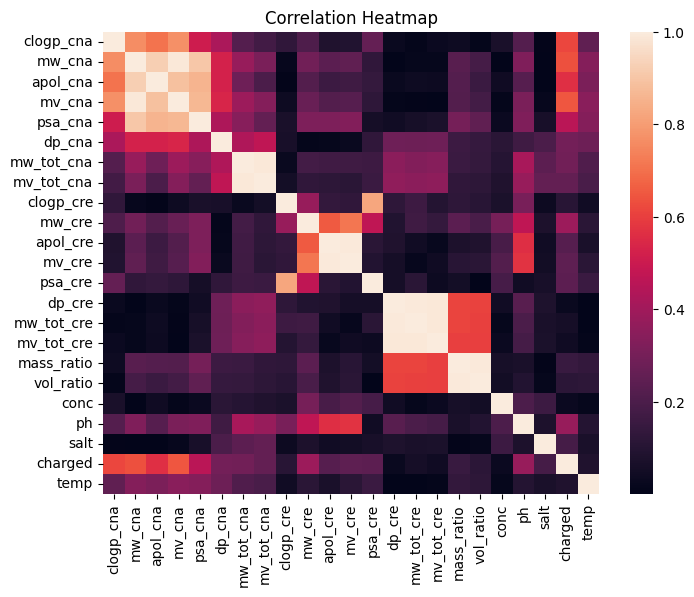

In [2]:
import data
from matplotlib import pyplot as plt
import seaborn as sns
from common import OUTPUTPATH

plt.figure(figsize=(8, 6))
# calculate the correlation matrix
corr = abs(data.abbrev_x1.corr())

# plot the heatmap
ax=sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set(title='Correlation Heatmap')

plt.savefig(os.path.join(OUTPUTPATH, 'correlation_heatmap.pdf'), bbox_inches='tight', pad_inches=0) # matrix sorting

In [3]:
# confusion matrix
import pandas as pd
predicted_order = [
        "(0,0,0)",
        "(1,0,0)",
        "(0,1,0)",
        "(0,0,1)",
        "(1,1,0)",
        "(1,0,1)",
        "(0,1,1)",
        "(1,1,1)",
        'Total'
    ]
def create_empty_df(predicted_order=predicted_order):
    df = pd.DataFrame(dict(zip(predicted_order, [[0 for _ in predicted_order] for _ in predicted_order]))) # specific columns order
    df.index = predicted_order # specific row order
    df = pd.concat([df], keys=['Predicted'])
    df = pd.concat([df.T], keys=['Actual'])
    return df
create_empty_df()



Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)         0       0       0       0       0       0       0   
       (1,0,0)         0       0       0       0       0       0       0   
       (0,1,0)         0       0       0       0       0       0       0   
       (0,0,1)         0       0       0       0       0       0       0   
       (1,1,0)         0       0       0       0       0       0       0   
       (1,0,1)         0       0       0       0       0       0       0   
       (0,1,1)         0       0       0       0       0       0       0   
       (1,1,1)         0       0       0       0       0       0       0   
       Total           0       0       0       0       0       0       0   

                              
               (1,1,1) Total  
Actual (0,0,0)       0     0  
       (1,0,0)       0     0  
       (0,1,0)       0     0  
       (0,0,1)       0     0  
       (1,1,0)       0     0  
       (1,0,1)       0     0  
       (0,1,1)       0     0  
       (1,1,1)       0     0  
       Total         0     0

In [4]:
import _pickle as cPickle
with open(r"./output/interpolation.pkl", "rb") as input_file:
    interpolation = cPickle.load(input_file)

with open(r"./output/extrapolation.pkl", "rb") as input_file:
    extrapolation = cPickle.load(input_file)

In [5]:
from modules.experiments import KFold

def modified_array(data): 
    return [ "(" + ",".join([str(code) for code in each[:-1]]) + ")" for each in data]

def confusion_matrix(model_name, splitter, groups, estimator=interpolation):
    """
    model_name: ['LR', 'GAM','RuleFit', 'RF']
    """
    df = create_empty_df()
    x, y = data.x1, data.y.replace(-1.0, 0.0)
    i = -1
    for train_idx, test_idx in splitter.split(x, y, groups):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        i +=1
        # LR
        est = estimator.fitted_[model_name][i]
        predicted = est.predict(x_test)
        predicted = modified_array(predicted)
        actual = modified_array(y_test.values)
        for i in range(len(predicted)):
            col, row = predicted_order.index(predicted[i]), predicted_order.index(actual[i])
            df.values[row][col] += 1
            df.values[row][-1] += 1
            df.values[-1][col] += 1
            df.values[-1][-1] += 1
    df = df/df.values[-1][-1]
    return df

In [6]:
# combine all the models
model_names = ['LR', 'GAM','RuleFit', 'RF']
seed=1000
df_interpolation = dict(zip(model_names,
              [confusion_matrix(each, 
                                KFold(30, shuffle=True, random_state=seed), 
                                groups=data.comp_ids.array,
                                estimator=interpolation) for each in model_names]))

In [7]:
from modules.experiments import GroupKFoldSpecial
df_extrapolation = dict(zip(model_names,
              [confusion_matrix(each, 
                                GroupKFoldSpecial(len(set(data.comp_ids)), size=22), 
                                groups=data.comp_ids.array,
                                estimator=extrapolation) for each in model_names]))

#### Interpolation model performance

* confusion matrix

In [278]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


def diff(a_list, b_list):
    return round(1-sum(np.array(a_list)==np.array(b_list))/len(a_list), 1)

def color_cell(a_list, b_list):
    # 1/3 red  #FF0000
    # 2/3 red  #CD0000
    # 3/3 red  #8B0000	
    # white #FFFAF0
    dif = diff(a_list, b_list)
    if dif == 1.0:
        return '#8B0000'
    elif dif == 0.0:
        return 'None'
    elif dif == 0.7:
        return "#CD0000"
    elif dif ==0.3:
        return '#ED3E3E'

def whole_color_cell(total_a_list, signle_b_list):
    color_list = []
    for each in total_a_list:
        color_list.append(color_cell(each, signle_b_list))
    return color_list
    

def format_float(num):
    if num== 0:
        return '-'
    elif num >= 1:
        return str(num)
    else:
        return str(num)[1:]

size_based_order = np.array([[0, 0, 0],
                    [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]])

                    
prob_colors = cm.get_cmap('OrRd')
target_counts = data.polymers[data.targets].replace(-1, 0).sum(axis=0).astype(np.int64)


h_mt = 16/17 # main table height

symb = np.vectorize(lambda x: 'x' if x==1 else ' ')
raw_row_list = list(symb(size_based_order))
row_list = [['S', ' ', ' '], [' ', 'W', ' '], [' ', ' ', 'V']] + raw_row_list


def find_index(index, alist=raw_row_list):
    index_list = []
    for i in range(len(alist)):
        if alist[i][index] == 'x':
            index_list.append(i)
    return index_list
    
def plot_confusion_matrix(dataframe, model_name, title=None, ax=None):
    ax = plt.gca() if ax is None else ax
    ax.table(cellText=np.array(row_list), bbox=[0, 1-h_mt, 3/12, h_mt], cellLoc='center', edges='open')
    ax.table(cellText=np.array([['322', '173', '200']]), cellColours = [[cm.gray(0.9)]*3], bbox=[0, 0, 3/12, 1/17], cellLoc='center', edges='closed')
    lr = round(dataframe[model_name], 3)
    col_sum = lr.values[-1]
    row_sum = lr.values[:, -1]
    lr = lr.values[:-1, :-1]

    # first columns
    for i in range(len(raw_row_list)):
        column_symbol = [[str(each)]for each in raw_row_list[i]]#+ [[str(each)]for each in lr[:, i]] + [[str(column_total)]]
        column_symbol = [each[0] for each in column_symbol]
        ax.table(cellText=column_symbol, cellLoc='center', 
        bbox=[3/12 + 1/12*(i), 1-h_mt/11*3, 1/12, h_mt/11*3], edges='open')

    # values table
    for i in range(lr.shape[0]):
        col_values = [[format_float(each) for each in lr[i]]]
        # return col_values
        ax.table(cellText=col_values, cellLoc='center', 
        cellColours = [whole_color_cell(raw_row_list, raw_row_list[i])],
        bbox=[3/12, 1-h_mt/11*(i+4), 8/12, h_mt/11], edges='closed')
    
    # total row
    ax.table(cellText=[[format_float(each) for each in col_sum]], cellLoc='center', cellColours = [[cm.gray(0.9)]*9],  bbox=[3/12, 0, 9/12, 1/17], edges='closed')

    find_index(0)
    # total column
    col1_values = int(np.sum(dataframe[model_name].values[:, find_index(0)])*592)
    col2_values = int(np.sum(dataframe[model_name].values[:, find_index(1)])*592)
    col3_values = int(np.sum(dataframe[model_name].values[:, find_index(2)])*592)
    ax.table(cellText=[[str(col1_values)], [str(col2_values)], [str(col3_values)]] + [[format_float(each)] for each in row_sum[:-1]], cellLoc='center', cellColours = [[cm.gray(0.9)]]*11,  bbox=[11/12, 1/17, 1/12, 16/17], edges='closed')

    ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False, labeltop=False)
    ax.tick_params(axis='y', left=False, labelleft=False)
    ax.set_title(title)


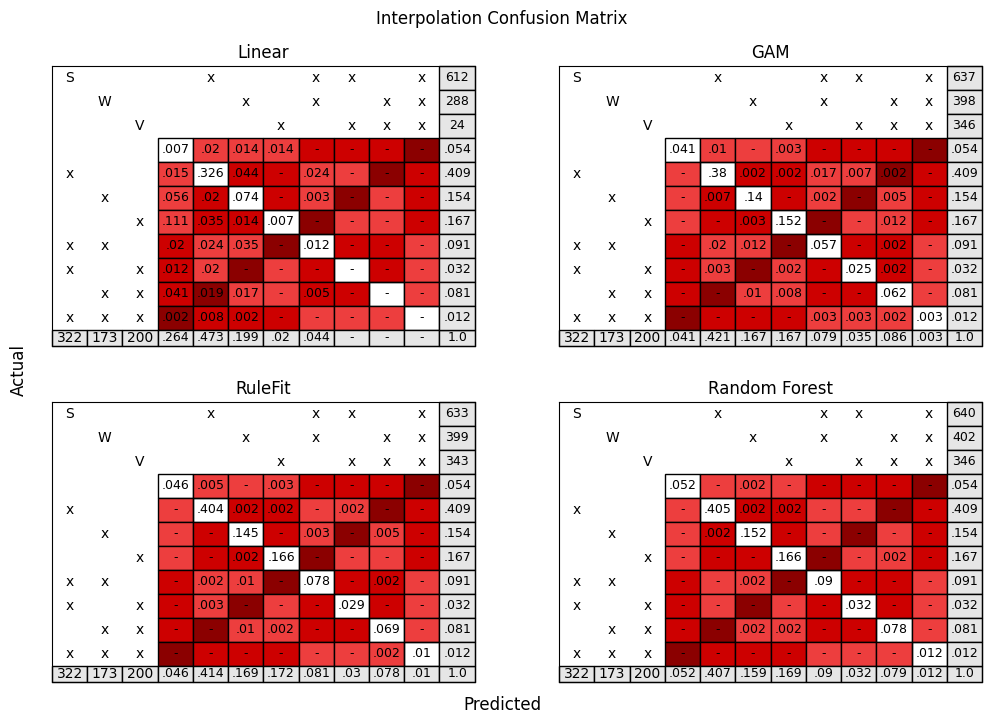

In [297]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_confusion_matrix(df_interpolation, 'LR', 'Linear', ax= axs[0][0])
plot_confusion_matrix(df_interpolation, 'GAM', 'GAM', ax= axs[0][1])
plot_confusion_matrix(df_interpolation, 'RuleFit', 'RuleFit', ax= axs[1][0])
plot_confusion_matrix(df_interpolation, 'RF', 'Random Forest', ax= axs[1][1])

fig.suptitle('Interpolation Confusion Matrix', y=0.95)
fig.supxlabel('Predicted', y=0.07)
fig.supylabel('Actual', x=0.09)
plt.savefig(os.path.join(OUTPUTPATH, 'interpolation_confusion_matrix.pdf'), bbox_inches='tight', pad_inches=0)

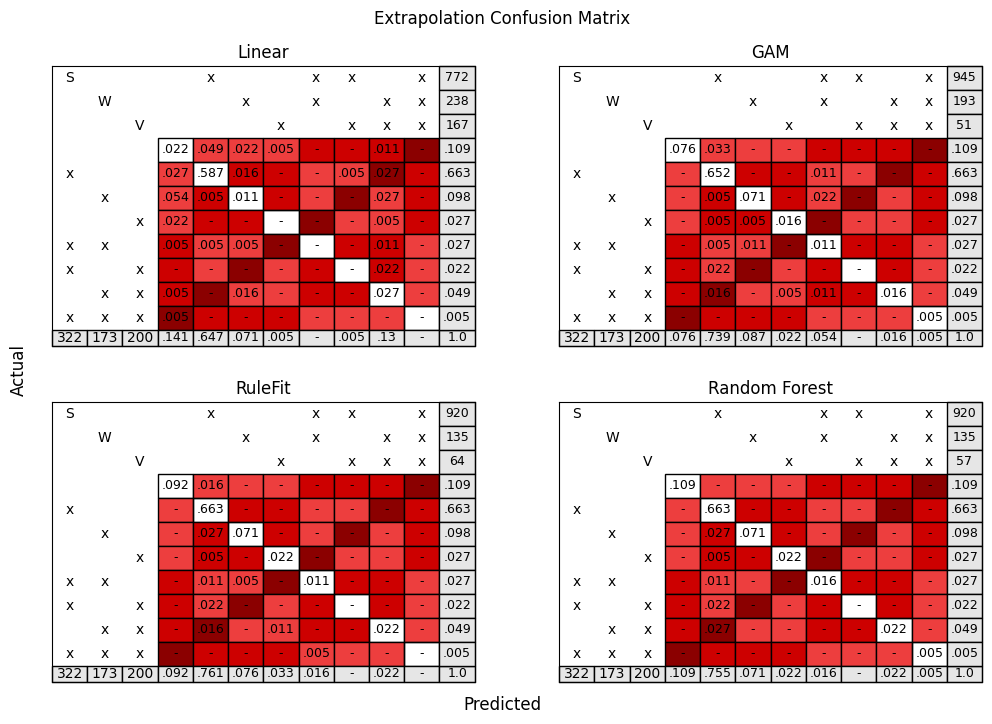

In [298]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_confusion_matrix(df_extrapolation, 'LR', 'Linear', ax= axs[0][0])
plot_confusion_matrix(df_extrapolation, 'GAM', 'GAM', ax= axs[0][1])
plot_confusion_matrix(df_extrapolation, 'RuleFit', 'RuleFit', ax= axs[1][0])
plot_confusion_matrix(df_extrapolation, 'RF', 'Random Forest', ax= axs[1][1])

fig.suptitle('Extrapolation Confusion Matrix', y=0.95)
fig.supxlabel('Predicted', y=0.07)
fig.supylabel('Actual', x=0.09)
plt.savefig(os.path.join(OUTPUTPATH, 'Extrapolaiton_confusion_matrix.pdf'), bbox_inches='tight', pad_inches=0)

In [9]:
# check confusion matrix actual total column
import numpy as np
np.unique([each[:-1] for each in data.y.values], return_counts=True, axis=0)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([ 32,  99,  91,  48, 242,  19,  54,   7]))

In [170]:
round(df_interpolation['GAM'],3) # GAM

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.041   0.010   0.000   0.003   0.000   0.000   0.000   
       (1,0,0)     0.000   0.380   0.002   0.002   0.017   0.007   0.002   
       (0,1,0)     0.000   0.007   0.140   0.000   0.002   0.000   0.005   
       (0,0,1)     0.000   0.000   0.003   0.152   0.000   0.000   0.012   
       (1,1,0)     0.000   0.020   0.012   0.000   0.057   0.000   0.002   
       (1,0,1)     0.000   0.003   0.000   0.002   0.000   0.025   0.002   
       (0,1,1)     0.000   0.000   0.010   0.008   0.000   0.000   0.062   
       (1,1,1)     0.000   0.000   0.000   0.000   0.003   0.003   0.002   
       Total       0.041   0.421   0.167   0.167   0.079   0.035   0.086   

                               
               (1,1,1)  Total  
Actual (0,0,0)   0.000  0.054  
       (1,0,0)   0.000  0.409  
       (0,1,0)   0.000  0.154  
       (0,0,1)   0.000  0.167  
       (1,1,0)   0.000  0.091  
       (1,0,1)   0.000  0.032  
       (0,1,1)   0.000  0.081  
       (1,1,1)   0.003  0.012  
       Total     0.003  1.000

In [172]:
round(df_interpolation['RuleFit'],3) # rulefit

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.046   0.005   0.000   0.003   0.000   0.000   0.000   
       (1,0,0)     0.000   0.404   0.002   0.002   0.000   0.002   0.000   
       (0,1,0)     0.000   0.000   0.145   0.000   0.003   0.000   0.005   
       (0,0,1)     0.000   0.000   0.002   0.166   0.000   0.000   0.000   
       (1,1,0)     0.000   0.002   0.010   0.000   0.078   0.000   0.002   
       (1,0,1)     0.000   0.003   0.000   0.000   0.000   0.029   0.000   
       (0,1,1)     0.000   0.000   0.010   0.002   0.000   0.000   0.069   
       (1,1,1)     0.000   0.000   0.000   0.000   0.000   0.000   0.002   
       Total       0.046   0.414   0.169   0.172   0.081   0.030   0.078   

                               
               (1,1,1)  Total  
Actual (0,0,0)    0.00  0.054  
       (1,0,0)    0.00  0.409  
       (0,1,0)    0.00  0.154  
       (0,0,1)    0.00  0.167  
       (1,1,0)    0.00  0.091  
       (1,0,1)    0.00  0.032  
       (0,1,1)    0.00  0.081  
       (1,1,1)    0.01  0.012  
       Total      0.01  1.000

In [173]:
round(df_interpolation['RF'],3) # random forest

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.052   0.000   0.002   0.000    0.00   0.000   0.000   
       (1,0,0)     0.000   0.405   0.002   0.002    0.00   0.000   0.000   
       (0,1,0)     0.000   0.002   0.152   0.000    0.00   0.000   0.000   
       (0,0,1)     0.000   0.000   0.000   0.166    0.00   0.000   0.002   
       (1,1,0)     0.000   0.000   0.002   0.000    0.09   0.000   0.000   
       (1,0,1)     0.000   0.000   0.000   0.000    0.00   0.032   0.000   
       (0,1,1)     0.000   0.000   0.002   0.002    0.00   0.000   0.078   
       (1,1,1)     0.000   0.000   0.000   0.000    0.00   0.000   0.000   
       Total       0.052   0.407   0.159   0.169    0.09   0.032   0.079   

                               
               (1,1,1)  Total  
Actual (0,0,0)   0.000  0.054  
       (1,0,0)   0.000  0.409  
       (0,1,0)   0.000  0.154  
       (0,0,1)   0.000  0.167  
       (1,1,0)   0.000  0.091  
       (1,0,1)   0.000  0.032  
       (0,1,1)   0.000  0.081  
       (1,1,1)   0.012  0.012  
       Total     0.012  1.000

/var/folders/c_/6873d_hj27z4bhy1l9x1tggnj8s0wd/T/ipykernel_62111/1490420595.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


Text(0.5, 1.03, 'Interpolation Confusion Matrix Heatmap')

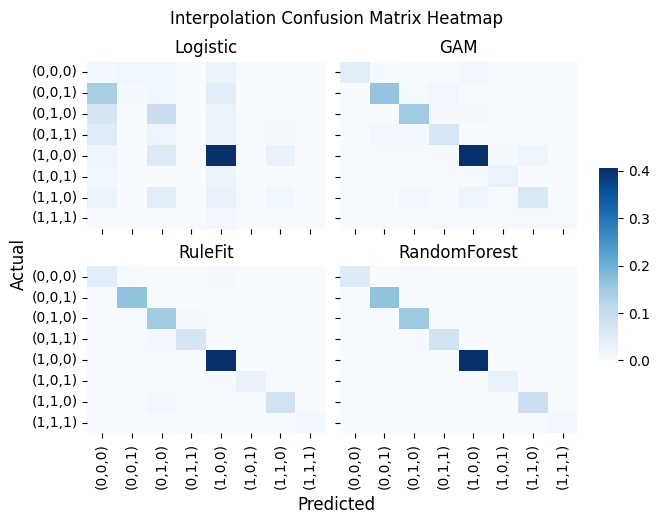

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def heatmap_subplot(df, title, ax=None, cbar=True, cbar_ax=None, cmap="Blues", predicted_order=predicted_order[:-1]):
    df = df.T['Actual'].drop(columns=['Total'])
    df = df.T['Predicted'].drop(columns=['Total'])

    sns.heatmap(df, 
            xticklabels=predicted_order,
            yticklabels=predicted_order, ax=ax, cbar=cbar, cbar_ax=cbar_ax, cmap=cmap).set(title=title)


fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

heatmap_subplot(df_interpolation['LR']/592, title='Logistic', ax=axn.flat[0], cbar=None)
heatmap_subplot(df_interpolation['GAM']/592, title='GAM', ax=axn.flat[1], cbar_ax=cbar_ax)
heatmap_subplot(df_interpolation['RuleFit']/592, title='RuleFit', ax=axn.flat[2], cbar_ax=cbar_ax)
heatmap_subplot(df_interpolation['RF']/592, title='RandomForest', ax=axn.flat[3], cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.supxlabel('Predicted', y=-0.02)
fig.supylabel('Actual', x=-0.01)
fig.suptitle('Interpolation Confusion Matrix Heatmap', y=1.03)

#### Extrapolation model performance

* confusion matrix

In [16]:
from modules.experiments import GroupKFoldSpecial
df_extrapolation = dict(zip(model_names,
              [confusion_matrix(each, 
                                GroupKFoldSpecial(len(set(data.comp_ids)), size=22), 
                                groups=data.comp_ids.array,
                                estimator=extrapolation) for each in model_names]))

In [174]:
round(df_extrapolation['LR'],3) # logistic model

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.022   0.049   0.022   0.005     0.0   0.000   0.011   
       (1,0,0)     0.027   0.587   0.016   0.000     0.0   0.005   0.027   
       (0,1,0)     0.054   0.005   0.011   0.000     0.0   0.000   0.027   
       (0,0,1)     0.022   0.000   0.000   0.000     0.0   0.000   0.005   
       (1,1,0)     0.005   0.005   0.005   0.000     0.0   0.000   0.011   
       (1,0,1)     0.000   0.000   0.000   0.000     0.0   0.000   0.022   
       (0,1,1)     0.005   0.000   0.016   0.000     0.0   0.000   0.027   
       (1,1,1)     0.005   0.000   0.000   0.000     0.0   0.000   0.000   
       Total       0.141   0.647   0.071   0.005     0.0   0.005   0.130   

                               
               (1,1,1)  Total  
Actual (0,0,0)     0.0  0.109  
       (1,0,0)     0.0  0.663  
       (0,1,0)     0.0  0.098  
       (0,0,1)     0.0  0.027  
       (1,1,0)     0.0  0.027  
       (1,0,1)     0.0  0.022  
       (0,1,1)     0.0  0.049  
       (1,1,1)     0.0  0.005  
       Total       0.0  1.000

In [175]:
round(df_extrapolation['GAM'],3) # GAM

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.076   0.033   0.000   0.000   0.000     0.0   0.000   
       (1,0,0)     0.000   0.652   0.000   0.000   0.011     0.0   0.000   
       (0,1,0)     0.000   0.005   0.071   0.000   0.022     0.0   0.000   
       (0,0,1)     0.000   0.005   0.005   0.016   0.000     0.0   0.000   
       (1,1,0)     0.000   0.005   0.011   0.000   0.011     0.0   0.000   
       (1,0,1)     0.000   0.022   0.000   0.000   0.000     0.0   0.000   
       (0,1,1)     0.000   0.016   0.000   0.005   0.011     0.0   0.016   
       (1,1,1)     0.000   0.000   0.000   0.000   0.000     0.0   0.000   
       Total       0.076   0.739   0.087   0.022   0.054     0.0   0.016   

                               
               (1,1,1)  Total  
Actual (0,0,0)   0.000  0.109  
       (1,0,0)   0.000  0.663  
       (0,1,0)   0.000  0.098  
       (0,0,1)   0.000  0.027  
       (1,1,0)   0.000  0.027  
       (1,0,1)   0.000  0.022  
       (0,1,1)   0.000  0.049  
       (1,1,1)   0.005  0.005  
       Total     0.005  1.000

In [176]:
round(df_extrapolation['RuleFit'],3) # rulefit

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.092   0.016   0.000   0.000   0.000     0.0   0.000   
       (1,0,0)     0.000   0.663   0.000   0.000   0.000     0.0   0.000   
       (0,1,0)     0.000   0.027   0.071   0.000   0.000     0.0   0.000   
       (0,0,1)     0.000   0.005   0.000   0.022   0.000     0.0   0.000   
       (1,1,0)     0.000   0.011   0.005   0.000   0.011     0.0   0.000   
       (1,0,1)     0.000   0.022   0.000   0.000   0.000     0.0   0.000   
       (0,1,1)     0.000   0.016   0.000   0.011   0.000     0.0   0.022   
       (1,1,1)     0.000   0.000   0.000   0.000   0.005     0.0   0.000   
       Total       0.092   0.761   0.076   0.033   0.016     0.0   0.022   

                               
               (1,1,1)  Total  
Actual (0,0,0)     0.0  0.109  
       (1,0,0)     0.0  0.663  
       (0,1,0)     0.0  0.098  
       (0,0,1)     0.0  0.027  
       (1,1,0)     0.0  0.027  
       (1,0,1)     0.0  0.022  
       (0,1,1)     0.0  0.049  
       (1,1,1)     0.0  0.005  
       Total       0.0  1.000

In [177]:
round(df_extrapolation['RF'],3) # random forest

Predicted                                                  \
                 (0,0,0) (1,0,0) (0,1,0) (0,0,1) (1,1,0) (1,0,1) (0,1,1)   
Actual (0,0,0)     0.109   0.000   0.000   0.000   0.000     0.0   0.000   
       (1,0,0)     0.000   0.663   0.000   0.000   0.000     0.0   0.000   
       (0,1,0)     0.000   0.027   0.071   0.000   0.000     0.0   0.000   
       (0,0,1)     0.000   0.005   0.000   0.022   0.000     0.0   0.000   
       (1,1,0)     0.000   0.011   0.000   0.000   0.016     0.0   0.000   
       (1,0,1)     0.000   0.022   0.000   0.000   0.000     0.0   0.000   
       (0,1,1)     0.000   0.027   0.000   0.000   0.000     0.0   0.022   
       (1,1,1)     0.000   0.000   0.000   0.000   0.000     0.0   0.000   
       Total       0.109   0.755   0.071   0.022   0.016     0.0   0.022   

                               
               (1,1,1)  Total  
Actual (0,0,0)   0.000  0.109  
       (1,0,0)   0.000  0.663  
       (0,1,0)   0.000  0.098  
       (0,0,1)   0.000  0.027  
       (1,1,0)   0.000  0.027  
       (1,0,1)   0.000  0.022  
       (0,1,1)   0.000  0.049  
       (1,1,1)   0.005  0.005  
       Total     0.005  1.000

/var/folders/c_/6873d_hj27z4bhy1l9x1tggnj8s0wd/T/ipykernel_62111/528931191.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


Text(0.5, 1.03, 'Extrapolation Confusion Matrix Heatmap')

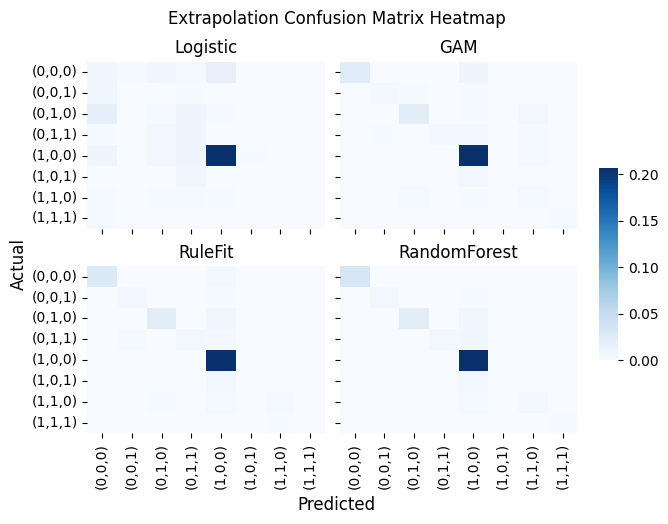

In [21]:
fig, axn = plt.subplots(2, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

heatmap_subplot(df_extrapolation['LR']/592, title='Logistic', ax=axn.flat[0], cbar=None)
heatmap_subplot(df_extrapolation['GAM']/592, title='GAM', ax=axn.flat[1], cbar_ax=cbar_ax)
heatmap_subplot(df_extrapolation['RuleFit']/592, title='RuleFit', ax=axn.flat[2], cbar_ax=cbar_ax)
heatmap_subplot(df_extrapolation['RF']/592, title='RandomForest', ax=axn.flat[3], cbar_ax=cbar_ax)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.supxlabel('Predicted', y=-0.02)
fig.supylabel('Actual', x=-0.01)
fig.suptitle('Extrapolation Confusion Matrix Heatmap', y=1.03)